In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import matplotlib.pyplot as plt
import numpy as np
import random
import gymnasium
import tqdm

In [68]:
# ----------------------------
# Device setup
# ----------------------------
def get_device():
    """Select available device (CUDA, MPS for Apple, or CPU)."""
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():  # macOS Metal
        device = torch.device("mps")
    elif torch.version.hip is not None and torch.cuda.is_available():
        device = torch.device("cuda")  # AMD ROCm usually appears as CUDA device
    else:
        device = torch.device("cpu")
    print(f"Using device: {device}")
    return device

In [69]:
# ----------------------------
# Seeding for reproducibility
# ----------------------------
def set_seed(seed):
    """Sets seed for reproducibility across libraries and devices."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [70]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc_1(x)
        x = F.relu(x)
        x = self.fc_2(x)
        return x

In [71]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            m.bias.data.zero_()

In [72]:
def train_episode(env, policy, optimizer, gamma, device):
    """Train policy for one episode."""
    policy.train()
    log_prob_actions, rewards = [], []
    done = False
    state, _ = env.reset()
    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        action_logits = policy(state_tensor)
        action_prob = F.softmax(action_logits, dim=-1)
        dist = distributions.Categorical(action_prob)
        action = dist.sample()

        next_state, reward, done, truncated, _ = env.step(action.item())
        done = done or truncated

        log_prob_actions.append(dist.log_prob(action))
        rewards.append(reward)
        state = next_state
        
    log_prob_actions = torch.stack(log_prob_actions)
    returns = calculate_returns(rewards, gamma, device, False)
    loss = update_policy(returns, log_prob_actions, optimizer)
    return loss, sum(rewards)


In [73]:
# ----------------------------
# Training and evaluation
# ----------------------------
def calculate_returns(rewards, gamma, device, normalize=True):
    """Compute discounted returns for an episode."""
    returns = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns, dtype=torch.float32, device=device)
    if normalize:
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
    return returns

In [74]:
def update_policy(returns, log_prob_actions, optimizer):
    """Compute loss and update policy parameters."""
    # returns = returns.detach()
    loss = -(returns * log_prob_actions).sum()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

In [75]:
def evaluate(env, policy, device):
    """Evaluate policy (greedy)."""
    policy.eval()
    done = False
    total_reward = 0
    state, _ = env.reset()

    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            action_logits = policy(state_tensor)
            action = torch.argmax(F.softmax(action_logits, dim=-1)).item()
        next_state, reward, done, truncated, _ = env.step(action)
        done = done or truncated
        total_reward += reward
        state = next_state

    return total_reward

In [76]:
# ----------------------------
# Main experiment
# ----------------------------
train_env = gymnasium.make('CartPole-v1')
test_env = gymnasium.make('CartPole-v1')

SEED = 1234
set_seed(SEED)
train_env.reset(seed=SEED) # Seed the environment upon reset
test_env.reset(seed=SEED+1) # Seed the environment upon reset

device_ = get_device()
# device_ = torch.device("cpu")

input_dim = train_env.observation_space.shape[0]
hidden_dim = 32
output_dim = train_env.action_space.n

n_runs = 5
max_episodes = 300
gamma_ = 0.99

train_rewards = torch.zeros(n_runs, max_episodes)
test_rewards = torch.zeros(n_runs, max_episodes)

for run in range(n_runs):
    policy_ = MLP(input_dim, hidden_dim, output_dim).to(device_)
    policy_.apply(init_weights)
    optimizer_ = optim.Adam(policy_.parameters(), lr=1e-2)

    for episode in tqdm.tqdm(range(max_episodes), desc=f"Run {run+1}/{n_runs}"):
        loss, tr = train_episode(train_env, policy_, optimizer_, gamma_, device_)
        te = evaluate(test_env, policy_, device_)
        train_rewards[run, episode] = tr
        test_rewards[run, episode] = te

Using device: cuda


Run 5/5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:10<00:00, 27.71it/s]


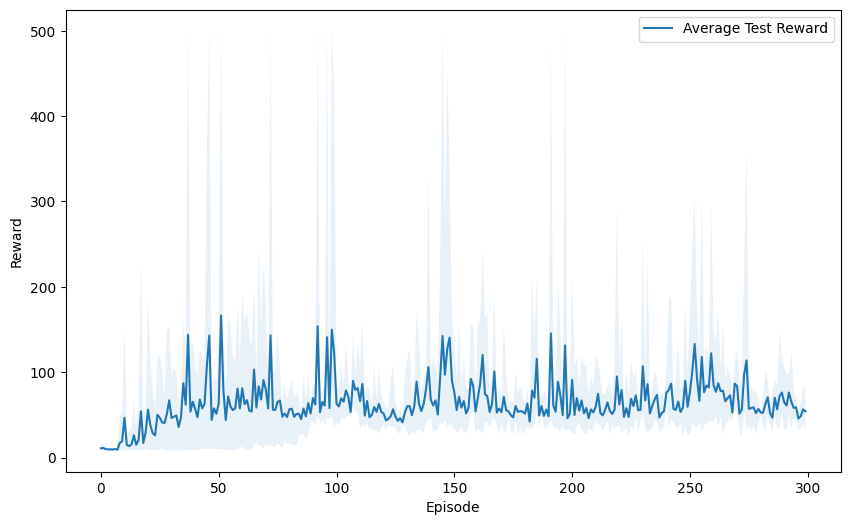

In [77]:
# Plot results
idxs = range(max_episodes)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(idxs, test_rewards.mean(0).cpu(), label="Average Test Reward")
ax.fill_between(
    idxs,
    test_rewards.min(0).values.cpu(),
    test_rewards.max(0).values.cpu(),
    alpha=0.1
)
ax.set_xlabel('Episode')
ax.set_ylabel('Reward')
ax.legend()
plt.show()